In [1]:
!pip install ipyleaflet==0.17
!pip install eemont
!pip install rasterio
!pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: ipyleaflet
    Found existing installation: ipyleaflet 0.18.2
    Uninstalling ipyleaflet-0.18.2:
      Successfully uninstalled ipyleaflet-0.18.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
geemap 0.32.1 requires ipyleaflet==0.18.2, but you have ipyleaflet 0.17.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eemont: filename=eemont-0.3.6-py3-none-any.whl size=135742 sha256=3210b084c5a57c8a5e78288808616c4aa6ac176c9be6012cda98ded887c09341
  S

In [2]:
import ee
import eemont
import geemap as geemap
import os
import math
import rasterio
from rasterio.windows import Window
import folium
import earthpy.plot as ep
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # statistical data visualization
import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection
import seaborn as sns # statistical data visualization

In [3]:
ee.Authenticate()
ee.Initialize(project='ee-andreagonnelli06')
# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

print('Folium version: ' + folium.__version__)


Folium version: 0.14.0


In [4]:
geojson = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"coordinates":[[12.78632055620858,42.18169545297127],[12.786010513010382,42.1814090541948],[12.785883097998038,42.18145626287344],[12.785475369956941,42.181843372711114],[12.785556066131477,42.18189687550978],[12.785161079591404,42.18210459183089],[12.785233281432284,42.18214235836135],[12.786010513010382,42.18176469204164],[12.786307814706504,42.18174895589581],[12.786329050542236,42.18169545297127]],"type":"LineString"}}]}
area = ee.FeatureCollection(geojson)


In [5]:
Map = geemap.Map(toolbar_ctrl=True, layer_ctrl=True)
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [6]:
rectangle=Map.draw_last_feature
rectangle.getInfo()
geometria=rectangle.geometry().getInfo()

coordinates=geometria['coordinates'][0]
coordinates1=coordinates[0]
coordinates2=coordinates[2]


In [7]:
rectangles = ee.Geometry.Rectangle([coordinates1, coordinates2])
def clippa(image):
  return image.clip(rectangles)

In [8]:
S1_PRS = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filterDate('2021-04-01', '2021-06-30')\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))\
    .filterBounds(rectangles)\
    .map(clippa);

In [9]:
S1_PRS_pc = S1_PRS.reduce(ee.Reducer.percentile([25,50,75]));
S1_PRS_pc = ee.Image(10).pow(S1_PRS_pc.divide(10));

S1_PRS_pc_Feats = S1_PRS_pc.select(['VH_p50','VV_p50']).clip(rectangles);
S1_PRS_pc_Feats = S1_PRS_pc_Feats.reproject(crs= 'EPSG:4326',scale= 30);

PRS_VV_iqr = S1_PRS_pc_Feats.addBands((S1_PRS_pc.select('VV_p75').subtract(S1_PRS_pc.select('VV_p25'))).rename('VV_iqr'));
PRS_VH_iqr = S1_PRS_pc_Feats.addBands((S1_PRS_pc.select('VH_p75').subtract(S1_PRS_pc.select('VH_p25'))).rename('VH_iqr'));
PRS_VV_iqr  = PRS_VV_iqr;
PRS_VH_iqr  = PRS_VH_iqr;

display('Post-rainy Season VV IQR', PRS_VV_iqr);

display('Post-rainy Season VV IQR', PRS_VH_iqr);

visvv = {'min': 0,'max': 0.1,'bands': 'VV_iqr'}
visvh = {'min': 0,'max': 0.1,'bands': 'VH_iqr'}

Map.addLayer(PRS_VV_iqr,visvv, 'Sentinel-1 IW VV');
Map.addLayer( PRS_VH_iqr,visvh, 'Sentinel-1 IW VH');

Map.centerObject(S1_PRS, 8)
Map


'Post-rainy Season VV IQR'

'Post-rainy Season VV IQR'

Map(bottom=24607.88671875, center=[42.06145787378263, 13.430863624206786], controls=(WidgetControl(options=['p…

In [10]:
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED');

def  maskS2clouds(image):
  qa = image.select('QA60');

  cloudBitMask = ee.Number(2).pow(10).int();
  cirrusBitMask = ee.Number(2).pow(11).int();

  mask = qa.bitwiseAnd(cloudBitMask).eq(0)&(qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.updateMask(mask).divide(10000);



composite = s2.filterDate('2021-04-01', '2021-06-30')\
                  .filterBounds(rectangles)\
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
                  .map(maskS2clouds)\
                  .select('B2', 'B3', 'B4','B5','B6','B7','B8','B11', 'B12')\
                  .map(clippa)

S2_composite = composite.median().reproject(crs= 'EPSG:4326', scale= 30);
display(S2_composite)
vis_s2 = {'min': 0, 'max': 0.3, 'bands': ['B11', 'B8', 'B3']};

Map.addLayer(S2_composite, vis_s2, 'Sentinel-2');
Map.centerObject(S1_PRS, 8)
Map

Map(bottom=24613.0, center=[42.06145787378263, 13.430863624206786], controls=(WidgetControl(options=['position…

In [11]:
canopy_ht = ee.ImageCollection("projects/meta-forest-monitoring-okw37/assets/CanopyHeight")\
.filterBounds(rectangles)\
.map(clippa)\
.select('cover_code')\
.first()

canopy_ht=canopy_ht.reproject(crs= 'EPSG:4326', scale= 30)
Map.addLayer(canopy_ht, {'min': 0, 'max': 10, 'palette': ['blue', 'yellow', 'orange', 'red']}, 'Canopy Height');
Map.centerObject(S1_PRS, 8)
Map

Map(bottom=24613.0, center=[42.06145787378263, 13.430863624206786], controls=(WidgetControl(options=['position…

In [12]:
SRTM = ee.Image("USGS/SRTMGL1_003");

elevation = SRTM.clip(rectangles);

elevation = elevation.reproject(crs='EPSG:4326',scale=30).int();
display(elevation)
slope = ee.Terrain.slope(SRTM).clip(rectangles);
display(slope)
slope = slope.reproject(crs='EPSG:4326',scale=30).int();

Map.addLayer(elevation, {'min': 0, 'max': 4000, 'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}, 'SRTM');
Map.addLayer(slope, {'min': 0, 'max': 90, 'palette': ['blue', 'yellow', 'orange', 'red']}, 'Slope');
Map.centerObject(S1_PRS, 8)
Map

Name,Description
elevation,Elevation


Map(bottom=24613.0, center=[42.06145787378263, 13.430863624206786], controls=(WidgetControl(options=['position…

In [13]:
mergedCollection = S2_composite.addBands(PRS_VV_iqr.addBands(PRS_VH_iqr.addBands(elevation.addBands(slope))).addBands(canopy_ht));

mergedCollection.int()

In [14]:
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'VV_iqr', 'VH_iqr', 'elevation', 'slope','cover_code'];


In [15]:
l4b = ee.ImageCollection('LARSE/GEDI/GEDI04_A_002_MONTHLY')\
.filterDate('2021-04-01', '2021-06-30')\
.filterBounds(rectangles)\
.median();

not_null = l4b.select('agbd').unmask()
aboveground = l4b.select('agbd')
maschera= aboveground.gt(0).mask()

# Applica il filtro all'immagine
dataset = aboveground.updateMask(maschera)
dataset=dataset.clip(rectangles).int();
display(dataset)

dataset1 = dataset.reproject(crs= 'EPSG:4326', scale=30);

Map.addLayer(dataset1,
    {'min': 10, 'max': 250, 'palette':['440154','414387','2a788e','23a884','7ad151','fde725']},
    'Mean Biomass');
Map.centerObject(S1_PRS, 8)
Map

Map(bottom=24613.0, center=[42.06145787378263, 13.430863624206786], controls=(WidgetControl(options=['position…

import time
for i in range(rectangles.size().getInfo()):
    # Ottieni la feature corrente
    feature = ee.Feature(rectangles.toList(rectangles.size()).get(i))
    
    # Campiona i dati spettrali per la feature corrente
    points=dataset1.sample(region=feature.geometry(),
    scale=30,
    numPixels=400000,
    geometries=True)

    display(points)

    ssample = mergedCollection.addBands(dataset1).sampleRegions(collection=points,
    properties=['agbd'],
    scale=30,
    geometries=True)
    display(ssample)
    
    # Esporta il campione in CSV
    nome_file = f'dati_campionati_{i}'
    task = ee.batch.Export.table.toDrive(
        collection=ssample,
        description=nome_file,
        folder='GEE_export',
        fileFormat='CSV'
    )
    task.start()
    
    # Attendi il completamento del task
    while task.active():
        print('Task in corso...')
        time.sleep(5)

print("Esportazione completata.")

In [16]:
points=dataset1.sample(region=rectangles,
   scale=30,
   numPixels=600000,
   geometries=True)

display(points)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
datawithColumn = points.randomColumn('random', 27);
split = 0.7;
trainingData = datawithColumn.filter(ee.Filter.lt('random', split));
display('training data', trainingData);
validationData = datawithColumn.filter(ee.Filter.gte('random', split));
display('validation data', validationData);

Output hidden; open in https://colab.research.google.com to view.

In [18]:
sample = mergedCollection.sampleRegions(collection=trainingData,
  properties=['agbd'],
  geometries=True)
display(sample)

vsample = mergedCollection.sampleRegions(collection=validationData,
  properties=['agbd'],
  geometries=True)
display(vsample)

Output hidden; open in https://colab.research.google.com to view.

In [19]:
classifier = ee.Classifier.smileRandomForest(100,variablesPerSplit	=5,minLeafPopulation=3,seed=2)\
  .train(
    features=sample,
    classProperty="agbd",
    inputProperties=bands
    );
vclassifier = ee.Classifier.smileRandomForest(100,variablesPerSplit	=5,minLeafPopulation=3,seed=2)\
  .train(
    features=vsample,
    classProperty="agbd",
    inputProperties=bands
    );
regression = mergedCollection.classify(classifier, 'predicted');
regression

In [20]:
classifier

In [21]:
predictedTraining = regression.sampleRegions(collection=trainingData, geometries=True);
sampleTraining = predictedTraining.select(['agbd', 'predicted']);
sampleTraining

Output hidden; open in https://colab.research.google.com to view.

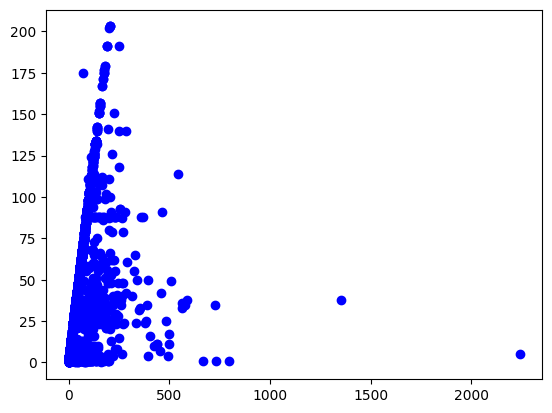

In [22]:
plt.plot(sampleTraining.aggregate_array('agbd').getInfo(), sampleTraining.aggregate_array('predicted').getInfo(), 'bo')
plt.show()

In [23]:
label = 'agbd'
validation_accuracy = sampleTraining.errorMatrix(label, 'predicted')
#display('Validation error matrix', validation_accuracy)
display('Validation accuracy', validation_accuracy.accuracy())

'Validation accuracy'

In [24]:
display('Results of trained classifier', classifier.explain())
# Get a confusion matrix and overall accuracy for the training sample.
train_accuracy = classifier.confusionMatrix()
#display('Training error matrix', train_accuracy)
display('Training overall accuracy', train_accuracy.accuracy())
label = 'agbd'
labell = ['agbd']

Output hidden; open in https://colab.research.google.com to view.

In [25]:
# Get a confusion matrix and overall accuracy for the validation sample.
predictedTest = regression.sampleRegions(collection=validationDataData, geometries=True);
sampleTest= predictedTest.select(['agbd', 'predicted']);
validation_sample = vsample.classify(classifier)
test_accuracy = validation_sample.errorMatrix(["agbd", "predicted"])
display(test_accuracy)
display(test_accuracy.accuracy().getInfo())
validation_accuracy = vclassifier.confusionMatrix()
#display('Validation error matrix', validation_accuracy)
display('Validation accuracy', validation_accuracy.accuracy())

NameError: name 'validationDataData' is not defined

In [26]:
# Classify the reflectance image from the trained classifier.
img_classified = mergedCollection.classify(classifier)
vis_params = {'bands': ['classification'], 'palette': ['#440154', ' #440256', ' #450457', ' #450559', ' #46075a', ' #46085c', ' #460a5d', ' #460b5e', ' #470d60', ' #470e61', ' #471063', ' #471164', ' #471365', ' #481467', ' #481668', ' #481769', ' #48186a', ' #481a6c', ' #481b6d', ' #481c6e', ' #481d6f', ' #481f70', ' #482071', ' #482173', ' #482374', ' #482475', ' #482576', ' #482677', ' #482878', ' #482979', ' #472a7a', ' #472c7a', ' #472d7b', ' #472e7c', ' #472f7d', ' #46307e', ' #46327e', ' #46337f', ' #463480', ' #453581', ' #453781', ' #453882', ' #443983', ' #443a83', ' #443b84', ' #433d84', ' #433e85', ' #423f85', ' #424086', ' #424186', ' #414287', ' #414487', ' #404588', ' #404688', ' #3f4788', ' #3f4889', ' #3e4989', ' #3e4a89', ' #3e4c8a', ' #3d4d8a', ' #3d4e8a', ' #3c4f8a', ' #3c508b', ' #3b518b', ' #3b528b', ' #3a538b', ' #3a548c', ' #39558c', ' #39568c', ' #38588c', ' #38598c', ' #375a8c', ' #375b8d', ' #365c8d', ' #365d8d', ' #355e8d', ' #355f8d', ' #34608d', ' #34618d', ' #33628d', ' #33638d', ' #32648e', ' #32658e', ' #31668e', ' #31678e', ' #31688e', ' #30698e', ' #306a8e', ' #2f6b8e', ' #2f6c8e', ' #2e6d8e', ' #2e6e8e', ' #2e6f8e', ' #2d708e', ' #2d718e', ' #2c718e', ' #2c728e', ' #2c738e', ' #2b748e', ' #2b758e', ' #2a768e', ' #2a778e', ' #2a788e', ' #29798e', ' #297a8e', ' #297b8e', ' #287c8e', ' #287d8e', ' #277e8e', ' #277f8e', ' #27808e', ' #26818e', ' #26828e', ' #26828e', ' #25838e', ' #25848e', ' #25858e', ' #24868e', ' #24878e', ' #23888e', ' #23898e', ' #238a8d', ' #228b8d', ' #228c8d', ' #228d8d', ' #218e8d', ' #218f8d', ' #21908d', ' #21918c', ' #20928c', ' #20928c', ' #20938c', ' #1f948c', ' #1f958b', ' #1f968b', ' #1f978b', ' #1f988b', ' #1f998a', ' #1f9a8a', ' #1e9b8a', ' #1e9c89', ' #1e9d89', ' #1f9e89', ' #1f9f88', ' #1fa088', ' #1fa188', ' #1fa187', ' #1fa287', ' #20a386', ' #20a486', ' #21a585', ' #21a685', ' #22a785', ' #22a884', ' #23a983', ' #24aa83', ' #25ab82', ' #25ac82', ' #26ad81', ' #27ad81', ' #28ae80', ' #29af7f', ' #2ab07f', ' #2cb17e', ' #2db27d', ' #2eb37c', ' #2fb47c', ' #31b57b', ' #32b67a', ' #34b679', ' #35b779', ' #37b878', ' #38b977', ' #3aba76', ' #3bbb75', ' #3dbc74', ' #3fbc73', ' #40bd72', ' #42be71', ' #44bf70', ' #46c06f', ' #48c16e', ' #4ac16d', ' #4cc26c', ' #4ec36b', ' #50c46a', ' #52c569', ' #54c568', ' #56c667', ' #58c765', ' #5ac864', ' #5cc863', ' #5ec962', ' #60ca60', ' #63cb5f', ' #65cb5e', ' #67cc5c', ' #69cd5b', ' #6ccd5a', ' #6ece58', ' #70cf57', ' #73d056', ' #75d054', ' #77d153', ' #7ad151', ' #7cd250', ' #7fd34e', ' #81d34d', ' #84d44b', ' #86d549', ' #89d548', ' #8bd646', ' #8ed645', ' #90d743', ' #93d741', ' #95d840', ' #98d83e', ' #9bd93c', ' #9dd93b', ' #a0da39', ' #a2da37', ' #a5db36', ' #a8db34', ' #aadc32', ' #addc30', ' #b0dd2f', ' #b2dd2d', ' #b5de2b', ' #b8de29', ' #bade28', ' #bddf26', ' #c0df25', ' #c2df23', ' #c5e021', ' #c8e020', ' #cae11f', ' #cde11d', ' #d0e11c', ' #d2e21b', ' #d5e21a', ' #d8e219', ' #dae319', ' #dde318', ' #dfe318', ' #e2e418', ' #e5e419', ' #e7e419', ' #eae51a', ' #ece51b', ' #efe51c', ' #f1e51d', ' #f4e61e', ' #f6e620', ' #f8e621', ' #fbe723', ' #fde725'], 'min': 2.0, 'max': 167.0, 'opacity': 1.0}
Map.addLayer(img_classified, vis_params, 'Classified')
Map


Map(bottom=24613.0, center=[42.06145787378263, 13.430863624206786], controls=(WidgetControl(options=['position…

In [34]:

Map.addLayer(area)
#somma dell'above ground biomass calcolata per il numero di pixel contenuti nell'area di progetto


Map(bottom=777356.8828125, center=[42.18364644061027, 12.805487439036371], controls=(WidgetControl(options=['p…

In [35]:
area_p=Map.draw_last_feature
area_p.getInfo()
progetto=area_p.geometry().getInfo()

posizioni=progetto['coordinates'][0]
posizioni1=posizioni[0]
posizioni2=posizioni[2]
area_di_progetto = ee.Geometry.Rectangle([posizioni1, posizioni2])
agb_project = img_classified.clip(area_di_progetto)
Map.addLayer(agb_project, vis_params, 'agb_project')
Map


Map(bottom=48627.8828125, center=[42.666517376962204, 14.143170118331911], controls=(WidgetControl(options=['p…

In [ ]:
pixel_counts = agb_project.reduceRegion(reducer=ee.Reducer.sum(), geometry=area, scale=30).getNumber('classification')
pixel_counts

In [28]:
belowgroundbiomass = pixel_counts*(0.2)
belowgroundbiomass
biomass = pixel_counts+belowgroundbiomass
biomass
carbon = biomass*(0.475)
carbon
Co2 = carbon*(3.67)

In [29]:
belowgroundbiomass

In [30]:
biomass

In [31]:
carbon

In [32]:
Co2

In [247]:
slope

In [ ]:
slope_aa=

In [36]:
desired_len = 1251855
slope_array = geemap.ee_to_numpy(slope, region=rectangles)
elevation_array = geemap.ee_to_numpy(elevation, region=rectangles)
canopy_array = geemap.ee_to_numpy(canopy_ht, region=rectangles)
gedit_array = geemap.ee_to_numpy(dataset1, region=rectangles)

Exception: Total request size (79797150 bytes) must be less than or equal to 50331648 bytes.

In [ ]:
B2_array = geemap.ee_to_numpy(S2_composite, region=rectangles, bands='B2')
B3_array = geemap.ee_to_numpy(S2_composite, region=rectangles, bands='B3')
B4_array = geemap.ee_to_numpy(S2_composite, region=rectangles, bands='B4')
B5_array = geemap.ee_to_numpy(S2_composite, region=rectangles, bands='B5')
B6_array = geemap.ee_to_numpy(S2_composite, region=rectangles, bands='B6')
B7_array = geemap.ee_to_numpy(S2_composite, region=rectangles, bands='B7')
B8_array = geemap.ee_to_numpy(S2_composite, region=rectangles, bands='B8')
B11_array = geemap.ee_to_numpy(S2_composite, region=rectangles, bands='B11')
B12_array = geemap.ee_to_numpy(S2_composite, region=rectangles, bands='B12')
PRS_VV_iqr_array = geemap.ee_to_numpy(PRS_VV_iqr, region=rectangles, bands='VV_iqr')
PRS_VH_iqr_array = geemap.ee_to_numpy(PRS_VH_iqr, region=rectangles, bands='VH_iqr')

B2_resize = np.resize(B2_array, desired_len)
B3_resize = np.resize(B3_array, desired_len)
B4_resize = np.resize(B4_array, desired_len)
B5_resize = np.resize(B5_array, desired_len)
B6_resize = np.resize(B6_array, desired_len)
B7_resize = np.resize(B7_array, desired_len)
B8_resize = np.resize(B8_array, desired_len)
B11_resize = np.resize(B11_array, desired_len)
B12_resize = np.resize(B12_array, desired_len)
PRS_VV_iqr_resize = np.resize(PRS_VV_iqr_array, desired_len)
PRS_VH_iqr_resize = np.resize(PRS_VH_iqr_array, desired_len)
canopy_resize = np.resize(canopy_array, desired_len)
gedi_resize = np.resize(gedit_array, desired_len)
slope_resize = np.resize(slope_array, desired_len)
elevation_resize = np.resize(elevation_array, desired_len)

In [244]:
features = {
    'B2': B2_resize.flatten(),
    'B3': B3_resize.flatten(),
    'B4': B4_resize.flatten(),
    'B5': B5_resize.flatten(),
    'B6': B6_resize.flatten(),
    'B7': B7_resize.flatten(),
    'B8': B8_resize.flatten(),
    'B11': B11_resize.flatten(),
    'B12': B12_resize.flatten(),
    'PRS_VV_iqr': PRS_VV_iqr_resize.flatten(),
    'PRS_VH_iqr': PRS_VH_iqr_resize.flatten(),
    'Elevation': elevation_resize.flatten(),
    'Slope': slope_resize.flatten(),
    'canopy_ht': canopy_resize.flatten(),
    'gedi': gedi_resize.flatten()
}
df = pd.DataFrame(features)

In [246]:
elevation_resize

array([-2147483648, -2147483648, -2147483648, ...,         660,
               659,         658], dtype=int32)

In [245]:
df

,B2,B3,B4,B5,B6,B7,B8,B11,B12,PRS_VV_iqr,PRS_VH_iqr,Elevation,Slope,canopy_ht,gedi
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,-2147483648,-2147483648,14,-2147483648
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,-2147483648,-2147483648,14,-2147483648
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,-2147483648,-2147483648,16,-2147483648
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,-2147483648,-2147483648,15,-2147483648
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,-2147483648,-2147483648,14,-2147483648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251850,0.02390,0.05770,0.02480,0.10780,0.32555,0.38610,0.39915,0.19700,0.08470,0.047767,0.013519,662,15,10,-2147483648
1251851,0.02490,0.05875,0.02835,0.10850,0.32710,0.38400,0.39460,0.20150,0.08815,0.030566,0.010099,661,13,9,-2147483648
1251852,0.02475,0.05990,0.02575,0.10840,0.32610,0.39730,0.40990,0.20105,0.08850,0.034930,0.009556,660,14,9,-2147483648
1251853,0.02320,0.06155,0.02550,0.10575,0.36295,0.45760,0.46920,0.19780,0.08400,0.046032,0.015737,659,18,8,-2147483648
